In [2]:
import ROOT as R
R.gStyle.SetOptFit(0)

def DrawSensitivity(method,syst,range_x):
    nameMap = {
    'gain_A':'IFG amp.',
    'gain_T':'IFG #tau',
    'stdp_A':'STDP amp.',
    'stdp_T':'STDP #tau',
    }

    fitRes = R.TFile('../output/Run2C_%smethod_%s_Scan_random_adhoc.root'%(method,syst))

    R_list = []
    chi2_list = []
    for n in range(20):
        func_name = 'func_28paras_run23_sjtu_Run2C_%smethod_%s_%s'%(method,syst,n)
        func = fitRes.Get(func_name)
        R_ = func.GetParameter(3)
        eR_ = func.GetParError(3)
        R_list.append([R_,eR_])
        chi2 = func.GetChisquare()
        ndf = func.GetNDF()
        chi2_list.append(chi2/ndf)


    c = R.TCanvas()

    fit_func = R.TF1('fit_func','[0]+[1]*x',range_x[0],range_x[1]-0.1)
    fit_func.SetParNames('Y-intercept','Sensitivity')
    fit_func.SetLineColor(2)
    fit_func.SetNpx(5000)



    R_graph = R.TGraphErrors()
    range_x_n = [int(range_x[0]/0.1),int(range_x[1]/0.1)]
    for n in range(*range_x_n):
        np = R_graph.GetN()
        # print (np,n*0.1)
        R_graph.SetPoint(np,n*0.1,R_list[n][0])
        R_graph.SetPointError(np,0,R_list[n][1])


    R_graph.Fit('fit_func','REMQ')    
    R_graph.SetTitle('Run2C, %s-method, %s scan;Multiplier;R [ppm]'%(method,nameMap[syst]))
    R_graph.Draw('AP')
    R_graph.GetYaxis().SetRangeUser(-72,-67)
    # print (range_x)
    R_graph.GetXaxis().SetRangeUser(range_x[0]-0.1,range_x[1])
    R_graph.SetMarkerStyle(8)
    R_graph.SetMarkerSize(0.8)
    R_graph.SetLineWidth(1)
    c.Draw()

    c2=R.TCanvas()
    chi2_graph = R.TGraph()

    for n in range(*range_x_n):
        chi2_graph.SetPoint(chi2_graph.GetN(),n*0.1,chi2_list[n])
    chi2_graph.SetTitle('Run2C, %s-method, %s scan;Multiplier;Chi2/NDF'%(method,nameMap[syst]))
    chi2_graph.Draw('ALP')

    chi2_graph.GetXaxis().SetRangeUser(range_x[0]-0.1,range_x[1])
    chi2_graph.SetMarkerStyle(8)
    chi2_graph.SetMarkerSize(0.8)
    chi2_graph.SetLineWidth(1)
    c2.Draw()
    return [c,c2],[chi2_graph,R_graph,fit_func,fitRes]

def GetParameterList(version,method,syst):
    f = R.TFile('../output/Run2C_%smethod_%s_%s.root'%(method,syst,version))
    val = []
    for n in range(20):
        func = f.Get('func_28paras_run23_sjtu_Run2C_%smethod_%s_%s'%(method,syst,n))
        R_ = func.GetParameter(3)
        eR_ = func.GetParError(3)
        chi2 = func.GetChisquare()
        ndf = func.GetNDF()
        val.append([R_,eR_,chi2/ndf])
    return val


def GetGraphs(pars,range_x):
    graph_R = R.TGraphErrors()
    graph_chi2 = R.TGraph()
    range_n = map(lambda x:int(x/0.1),range_x)
    for n in range(*range_n):
        x = n*0.1
        np = graph_R.GetN()
        graph_R.SetPoint(np,x,pars[n][0])
        graph_R.SetPointError(np,0,pars[n][1])
        graph_chi2.SetPoint(np,x,pars[n][2])
    return graph_R,graph_chi2

def DrawChi2Cmp(method,syst,range_x,legPos):
    nameMap = {
    'gain_A':'In-fill gain amp.',
    'gain_T':'In-fill gain #tau',
    'stdp_A':'STDP amp.',
    'stdp_T':'STDP #tau',
    }    
    versions = ['Scan','Scan_random','Scan_random_adhoc_fix']
    colors = [R.kBlack,R.kRed,R.kBlue]
    names = ['Raw','Randomized','Randomized+Ad-hoc']

    multi_g_chi2 = R.TMultiGraph()
    graphs_chi2 = []

    range_n = map(lambda x:int(x/0.1),range_x)
    for n in range(3):
        version = versions[n]
        
        pars = GetParameterList(version,method,syst)
        graph_R, graph_chi2 = GetGraphs(pars,range_x)

        graph_chi2.SetLineColor(colors[n])
        graph_chi2.SetTitle(names[n])
        graph_chi2.SetLineWidth(1)
        graph_chi2.SetMarkerStyle(8)
        graph_chi2.SetMarkerColor(colors[n])
        
        graph_chi2.SetMarkerSize(0.8)
        multi_g_chi2.Add(graph_chi2)
        graphs_chi2.append(graph_chi2)
        
        
    c = R.TCanvas()
    multi_g_chi2.Draw('ALP')
    multi_g_chi2.SetTitle('%s scan (%s-method);Multiplier;#chi^{2}/NDF'%(nameMap[syst],method))
    c.BuildLegend(*legPos)
    c.Draw()
    return c,multi_g_chi2,graph_chi2,graphs_chi2 

def DrawSensitivityCmp(method,syst,range_x,legPos,rangey=[-80,-60]):
    nameMap = {
    'gain_A':'In-fill gain amp.',
    'gain_T':'In-fill gain #tau',
    'stdp_A':'STDP amp.',
    'stdp_T':'STDP #tau',
    }

    versions = ['Scan','Scan_random','Scan_random_adhoc_fix']
    colors = [R.kBlack,R.kRed,R.kBlue]
    names = ['Raw','Randomized','Randomized+Ad-hoc']

    funcs = []
    graphs_R = []
    range_n = map(lambda x:int(x/0.1),range_x)
    c = R.TCanvas()
    
    multi_g_R = R.TMultiGraph()
    for n in range(3):
        version = versions[n]
        
        pars = GetParameterList(version,method,syst)
        graph_R, graph_chi2 = GetGraphs(pars,range_x)
        fit_func = R.TF1('fit_func%s'%(n),'[0]+[1]*x',range_x[0],range_x[1]-0.1)
        fit_func.SetParNames('Y-intercept','Sensitivity')
        fit_func.SetLineColor(colors[n])
        fit_func.SetNpx(5000)
        graph_R.Fit(fit_func)
        funcs.append(fit_func)
        fit_func.Draw('same')

        graph_R.SetLineColor(colors[n])
        graph_R.SetTitle(names[n])
        graph_R.SetLineWidth(1)
        graph_R.SetMarkerStyle(8)
        graph_R.SetMarkerColor(colors[n])
        
        graph_R.SetMarkerSize(0.8)
        multi_g_R.Add(graph_R)
        graphs_R.append(graph_R)

    multi_g_R.Draw('ALP')    
    multi_g_R.SetTitle('%s scan (%s-method);Multiplier;R [ppm]'%(nameMap[syst],method))
    multi_g_R.GetYaxis().SetRangeUser(*rangey)
    c.Draw()
    c.BuildLegend(*legPos)
    return c,funcs,graphs_R,multi_g_R
    
    

 FCN=7.41153e-05 FROM MIGRAD    STATUS=CONVERGED      35 CALLS          36 TOTAL
                     EDM=1.50988e-20    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Y-intercept  -6.97136e+01   2.41673e-01   8.46366e-05   1.33939e-09
   2  Sensitivity   9.21601e-02   2.17481e-01   7.61645e-05   1.47716e-09
 FCN=6.03406e-05 FROM MIGRAD    STATUS=CONVERGED      35 CALLS          36 TOTAL
                     EDM=7.51831e-22    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Y-intercept  -6.97676e+01   2.31041e-01   8.48247e-05  -3.13084e-10
   2  Sensitivity   9.54524e-02   2.09547e-01   7.69335e-05  -3.40255e-10
 FCN=0.000119464 FROM MIGRAD    STATUS=CONVERGED      35 CALLS          36 TOTAL
             

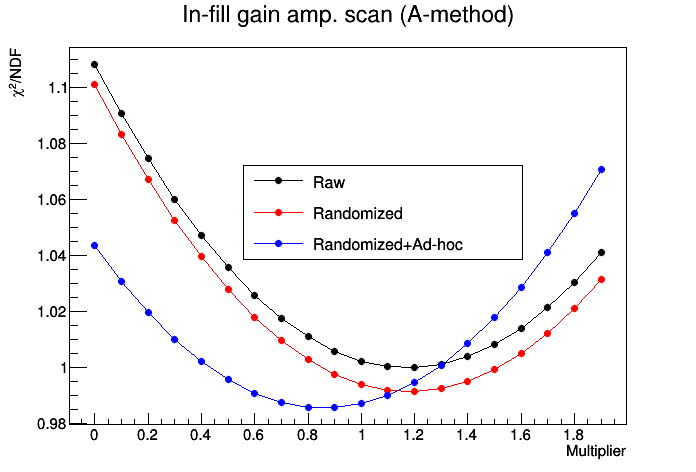

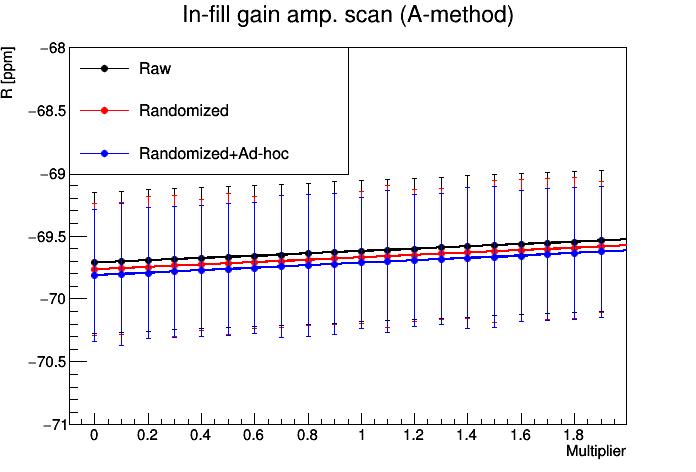

In [7]:
# compare chi2 cross versions
method = 'A'
syst = 'gain_A'
range_x = [0.,2.]
legPos = [0.35,0.45,0.75,0.65]
c1 = DrawChi2Cmp(method,syst,range_x,legPos)





legPos = [0.1,0.63,0.5,0.9]
rangey = [-71,-68]
c2 = DrawSensitivityCmp(method,syst,range_x,legPos,rangey)

# method = 'A'
# syst = 'gain_T'
# range_x = [0.5,1.5]
# legPos = [0.1,0.6,0.5,0.8]
# c2 = DrawChi2Cmp(method,syst,range_x,legPos)

# method = 'A'
# syst = 'stdp_A'
# range_x = [0.5,1.5]
# legPos = [0.1,0.6,0.5,0.8]
# c3 = DrawChi2Cmp(method,syst,range_x,legPos)

# method = 'A'
# syst = 'stdp_T'
# range_x = [0.5,1.5]
# legPos = [0.1,0.6,0.5,0.8]
# c4 = DrawChi2Cmp(method,syst,range_x,legPos)

 FCN=1.20923e-05 FROM MIGRAD    STATUS=CONVERGED      35 CALLS          36 TOTAL
                     EDM=1.40275e-22    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Y-intercept  -6.96249e+01   2.41689e-01   8.44043e-05   1.28629e-10
   2  Sensitivity   3.01444e-03   2.17481e-01   7.59503e-05   1.42939e-10
 FCN=9.36989e-06 FROM MIGRAD    STATUS=CONVERGED      35 CALLS          36 TOTAL
                     EDM=1.96457e-21    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Y-intercept  -6.96745e+01   2.41111e-01   8.33481e-05  -4.90947e-10
   2  Sensitivity   2.80253e-03   2.17179e-01   7.50753e-05  -5.43856e-10
 FCN=6.25407e-06 FROM MIGRAD    STATUS=CONVERGED      35 CALLS          36 TOTAL
             

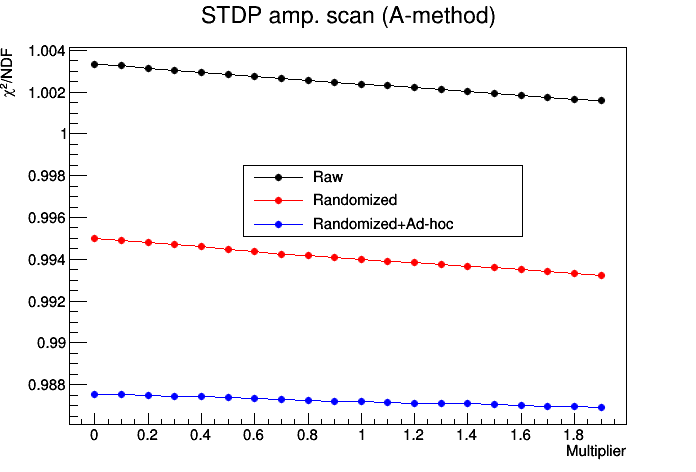

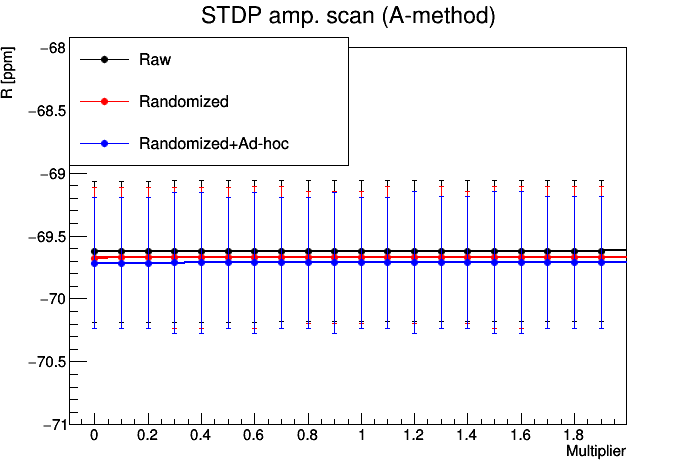

In [11]:
method = 'A'
syst = 'stdp_A'
range_x = [0.,2.]
legPos = [0.35,0.5,0.75,0.65]
c1 = DrawChi2Cmp(method,syst,range_x,legPos)





legPos = [0.1,0.65,0.5,0.92]
rangey = [-71,-68]
c2 = DrawSensitivityCmp(method,syst,range_x,legPos,rangey)

 FCN=0.000512716 FROM MIGRAD    STATUS=CONVERGED      35 CALLS          36 TOTAL
                     EDM=1.46218e-21    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Y-intercept  -6.95334e+01   2.68048e-01   8.44188e-05  -3.73424e-10
   2  Sensitivity   9.29018e-02   2.41215e-01   7.59679e-05  -4.17137e-10
 FCN=0.000618819 FROM MIGRAD    STATUS=CONVERGED      35 CALLS          36 TOTAL
                     EDM=3.79424e-21    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Y-intercept  -6.95414e+01   2.48450e-01   8.57967e-05   6.40633e-10
   2  Sensitivity   9.35122e-02   2.27947e-01   7.87165e-05   6.92184e-10
 FCN=0.000324868 FROM MIGRAD    STATUS=CONVERGED      35 CALLS          36 TOTAL
             

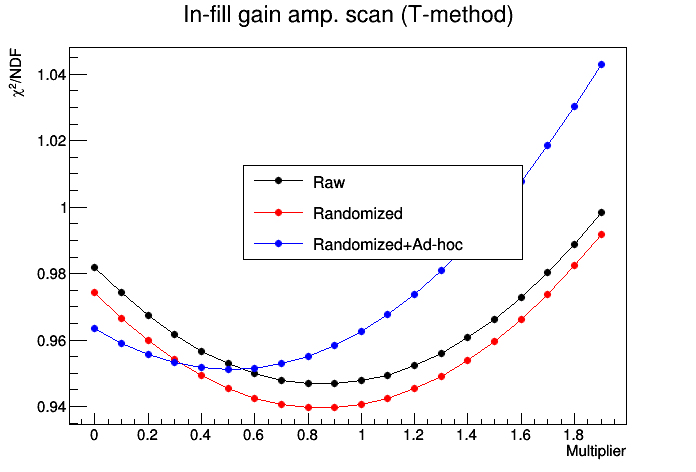

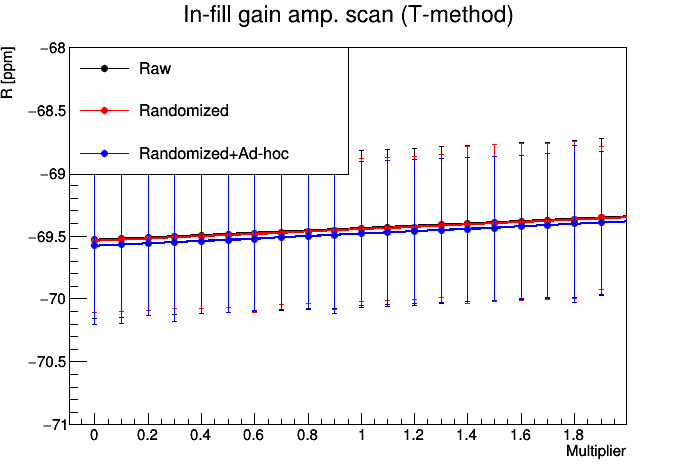

In [12]:
# compare chi2 cross versions
method = 'T'
syst = 'gain_A'
range_x = [0.,2.]
legPos = [0.35,0.45,0.75,0.65]
c1 = DrawChi2Cmp(method,syst,range_x,legPos)





legPos = [0.1,0.63,0.5,0.9]
rangey = [-71,-68]
c2 = DrawSensitivityCmp(method,syst,range_x,legPos,rangey)

 FCN=3.9895e-05 FROM MIGRAD    STATUS=CONVERGED      35 CALLS          36 TOTAL
                     EDM=2.11994e-21    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Y-intercept  -6.94450e+01   2.68060e-01   8.41856e-05  -4.55649e-10
   2  Sensitivity   2.08264e-03   2.41211e-01   7.57536e-05  -4.94833e-10
 FCN=6.31859e-05 FROM MIGRAD    STATUS=CONVERGED      35 CALLS          36 TOTAL
                     EDM=8.39182e-20    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Y-intercept  -6.94527e+01   2.37669e-01   7.65000e-05  -3.60726e-09
   2  Sensitivity   2.57513e-03   1.82216e-01   5.86511e-05  -4.64754e-09
 FCN=1.96012e-05 FROM MIGRAD    STATUS=CONVERGED      35 CALLS          36 TOTAL
              

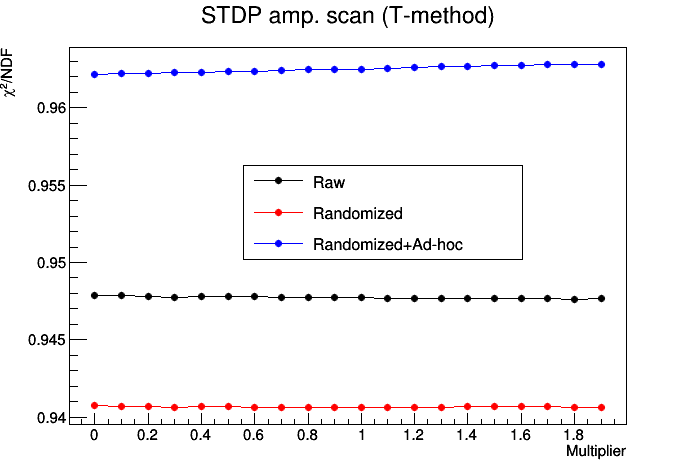

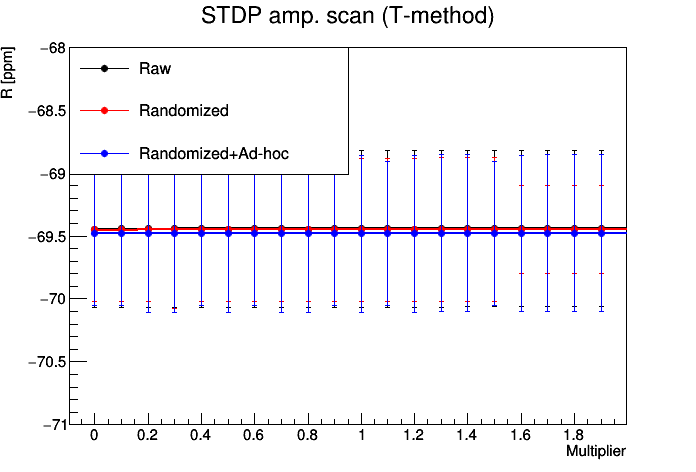

In [13]:
# compare chi2 cross versions
method = 'T'
syst = 'stdp_A'
range_x = [0.,2.]
legPos = [0.35,0.45,0.75,0.65]
c1 = DrawChi2Cmp(method,syst,range_x,legPos)





legPos = [0.1,0.63,0.5,0.9]
rangey = [-71,-68]
c2 = DrawSensitivityCmp(method,syst,range_x,legPos,rangey)